In [ ]:
from google.colab import drive
import os
import shutil
import cv2
from tqdm import tqdm
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_dir = "/content/gdrive/MyDrive/Brain_Tumor_Project"

def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
TRAIN_DIR = data_dir + '/Train/'
VAL_DIR = data_dir + '/Val/'
TEST_DIR = data_dir + '/Test/'
RANDOM_SEED = 123
IMG_SIZE = (240, 240)
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    seed=RANDOM_SEED,
    shuffle = False
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='categorical',
    seed=RANDOM_SEED,
    shuffle = False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='categorical',
    seed=RANDOM_SEED,
    shuffle = False
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [ ]:
from keras.models import Model

model = VGG16(include_top=False, input_shape=IMG_SIZE + (3,))

for layer in model.layers:
	layer.trainable = False

flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
drop = Dropout(0.5)(class1)
class2 = Dense(512, activation='relu')(drop)
class3 = Dense(256, activation='relu')(class2)
class4 = Dense(128, activation='relu')(class3)
output = Dense(2, activation='softmax')(class4)

In [ ]:
model = Model(inputs = model.input, outputs = output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0   

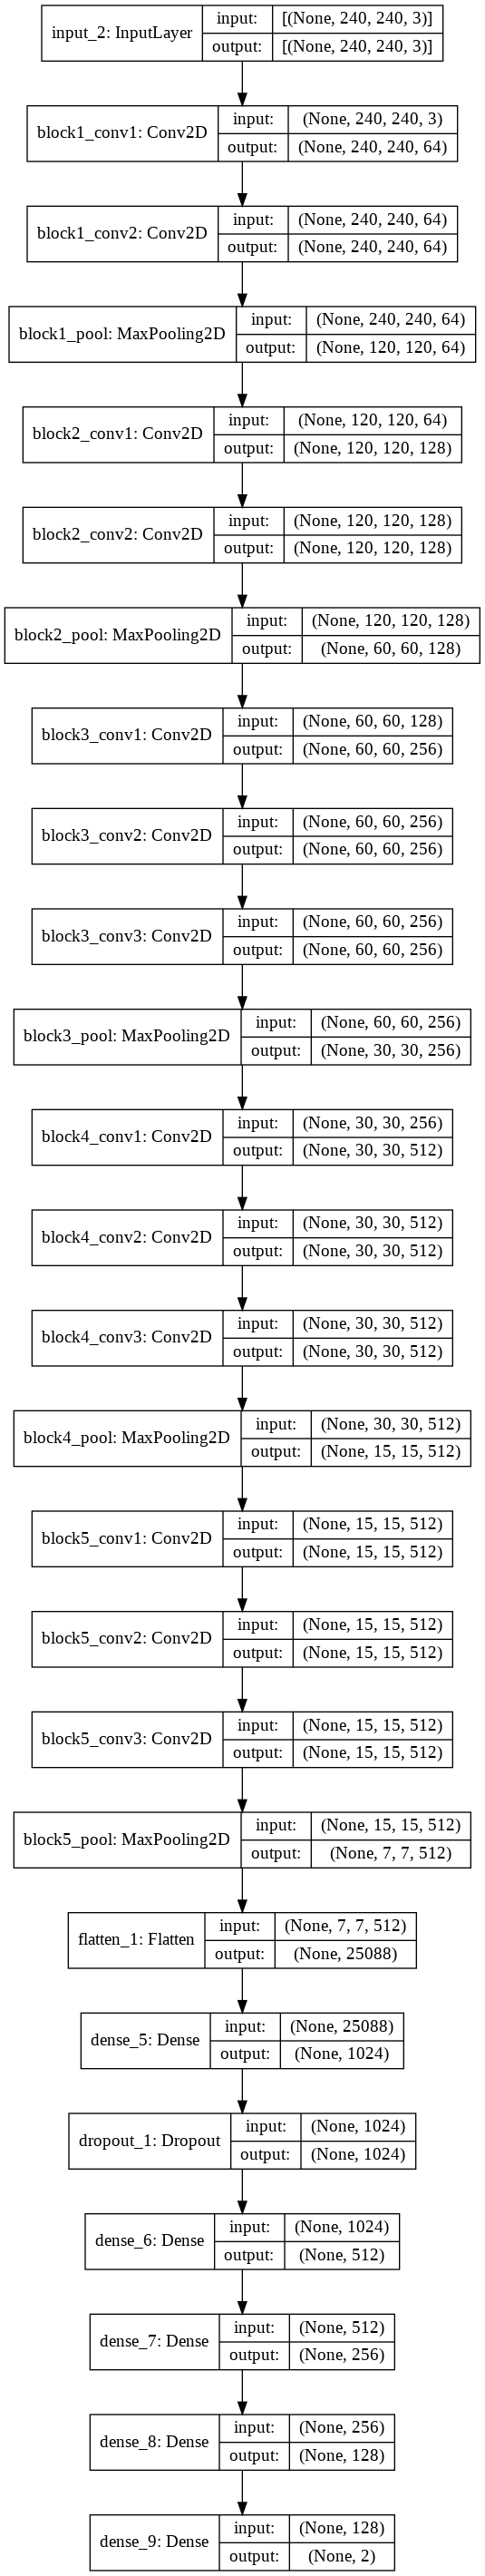

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model_architecture.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
train_generator.class_indices

{'No': 0, 'Yes': 1}

In [ ]:
EPOCHS = 100
es = EarlyStopping(
    monitor='accuracy', 
    mode='max',
    patience=10,
    verbose = 1
)
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint(data_dir + '/mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose = 1)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit_generator(train_generator, epochs = EPOCHS,  validation_data=validation_generator,callbacks=[es, mcp_save], verbose = True)

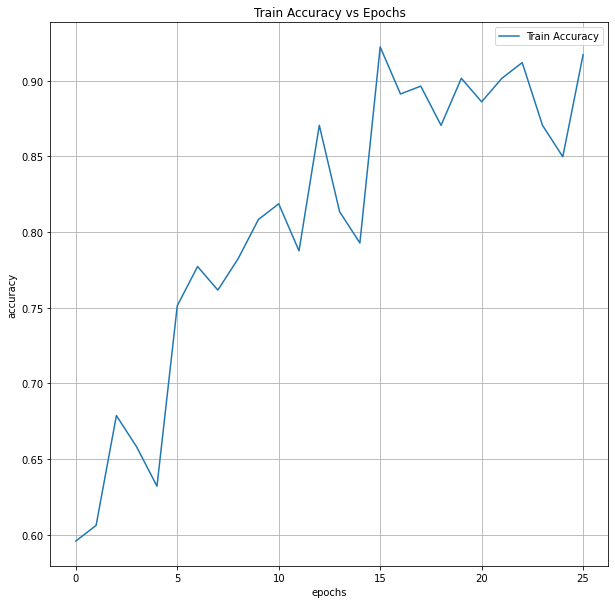

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
plt.plot(history.history['accuracy'], )
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['Train Accuracy'])
plt.title('Train Accuracy vs Epochs')
plt.grid(True)

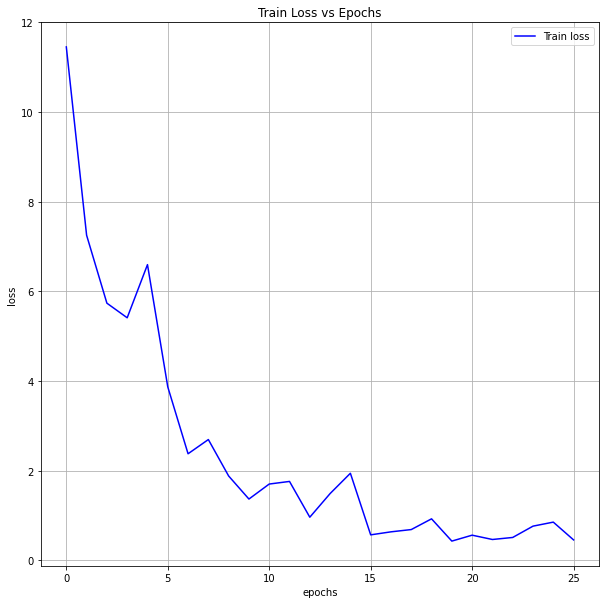

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(history.history['loss'], color = 'blue')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Train loss'])
plt.title('Train Loss vs Epochs')
plt.grid(True)

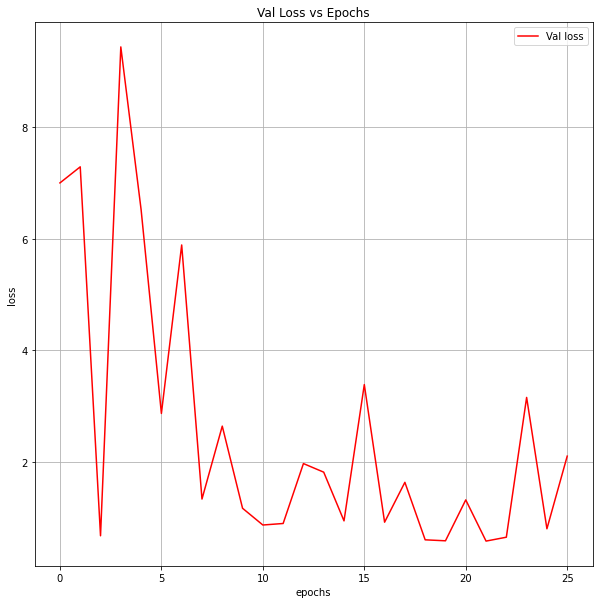

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(history.history['val_loss'], color = 'red')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Val loss'])
plt.title('Val Loss vs Epochs')
plt.grid(True)

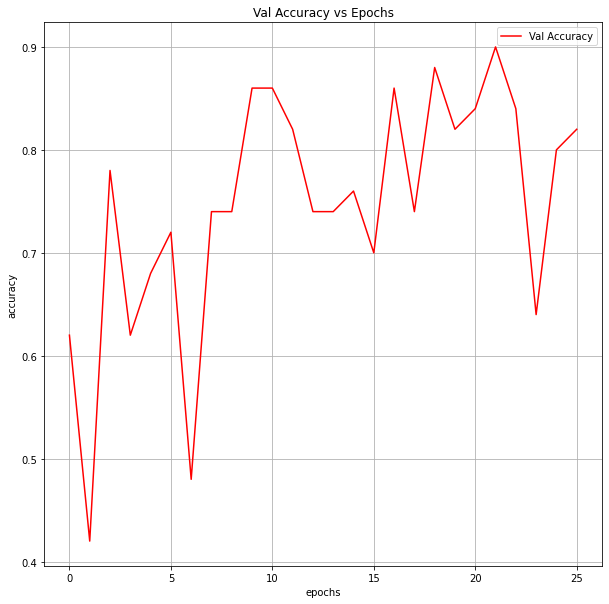

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(history.history['val_accuracy'], color = 'red')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['Val Accuracy'])
plt.title('Val Accuracy vs Epochs')
plt.grid(True)

In [ ]:
model.load_weights("/content/gdrive/MyDrive/Brain_Tumor_Project/mdl_wts.hdf5")

In [ ]:
train_pred = np.argmax(model.predict(train_generator), axis = 1)
val_pred = np.argmax(model.predict(validation_generator), axis = 1)
test_pred = np.argmax(model.predict(test_generator), axis = 1)

print("Train Accuracy: " + str(accuracy_score(train_generator.classes, train_pred)))
print("Val Accuracy: " + str(accuracy_score(validation_generator.classes, val_pred)))
print("Test Accuracy: " + str(accuracy_score(test_generator.classes, test_pred)))

Train Accuracy: 0.9637305699481865
Val Accuracy: 0.9
Test Accuracy: 0.9


In [ ]:
cnf_mat = confusion_matrix(test_generator.classes, test_pred)

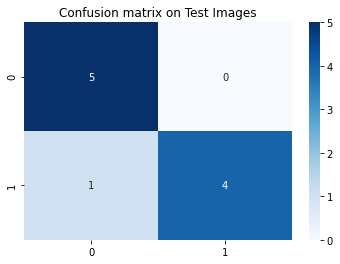

In [ ]:
sns.heatmap(cnf_mat, annot=True, cmap='Blues')
plt.savefig('Confusion_matrix_Val')
plt.title("Confusion matrix on Test Images")
plt.show()